In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import copy
import numpy as np



/home/mpim/m300733/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/mpim/m300733/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from typhon import plots

import konrad
plev, phlev = konrad.utils.get_pressure_grids(1000e2, 1, 201)
atmosphere = konrad.atmosphere.Atmosphere(plev)
solarConstant=480
Albedo=0.2
fixedRH=0.4
pressureLimitIndex=165
maxDuration='3000d'
maxDuration2='200d'
upwellingVelocity=0
year=1991
pressureMin=10
zenith_angle =42.05
run=str(9)
fixedWater=0
 
convergenceFile='convergence'+run+'.nc'
convergenceFileAerosol='convergenceAerosol'+run+'.nc'
convergenceInputPath='/scratch/local1/m300733/'+convergenceFile
convergenceInputPathAerosol='/scratch/local1/m300733/'+convergenceFileAerosol
stratospheric_upwelling = konrad.upwelling.StratosphericUpwelling(w=upwellingVelocity)

# Load a standard atmosphere.
#atmosphere = konrad.atmosphere.Atmosphere.from_netcdf(
#    ncfile='data/tropical-standard.nc',
#)
atmosphere.tracegases_rcemip()  # Atmosphere composition according to RCEMIP.

# Plot the initial temperature profile (for comparison).
plt.style.use(plots.styles('typhon'))
fig, ax = plt.subplots()
#plots.profile_p_log(atmosphere['plev'], atmosphere['T'][-1, :], label='Initial state')
atmosphere.tracegases_rcemip()  # Atmosphere composition according to RCEMIP.
# Initialize the setup for the radiative-convective equilibrium simulation.
rce = konrad.RCE(
    atmosphere,
    #surface=surface,
    radiation=konrad.radiation.RRTMG(solar_constant=solarConstant,zenith_angle =zenith_angle),  # Use RRTMG radiation scheme.
    surface=konrad.surface.SurfaceHeatCapacity(albedo=Albedo),
    #convection=konrad.convection.HardAdjustment(),  # Perform a hard convective adjustment.
    convection=konrad.convection.RelaxedAdjustment(),
    lapserate=konrad.lapserate.MoistLapseRate(),  # Adjust towards a moist adiabat.
    timestep='16h',  # Set timestep in model time.
    #humidity=konrad.humidity.FixedRH(rh_func=konrad.humidity.FixedUTH()),
    humidity=konrad.humidity.FixedRH(rh_func=konrad.humidity.HeightConstant(rh_surface=fixedRH)), 
    upwelling=stratospheric_upwelling,
    max_duration=maxDuration,  # Set maximum runtime.
    aerosol=konrad.aerosol.NoAerosol(),
    outfile=convergenceInputPath ,
    writeevery=200,
)
rce.run()  # Start the simulation.
# Plot the equilibrium temperature profile.
noAerosolAtm=atmosphere.copy()
equiNoAeroInput1=atmosphere.copy()
equiNoAeroInput2=atmosphere.copy()
plots.profile_p_log(atmosphere['plev'][0:pressureLimitIndex], atmosphere['T'][-1, 0:pressureLimitIndex], label='no aerosol')
ax = plt.gca()
ax.set_ylim([pressureMin,max(atmosphere['plev'])])
plt.gca().invert_yaxis()
ax.legend()
#plev, phlev = konrad.utils.get_pressure_grids(1000e2, 1, 201)
#atmosphere = konrad.atmosphere.Atmosphere(plev)
# Initialize the setup for the radiative-convective equilibrium simulation.
rce = konrad.RCE(
    equiNoAeroInput1,
    surface=konrad.surface.SurfaceHeatCapacity(albedo=Albedo),
    radiation=konrad.radiation.RRTMG(solar_constant=solarConstant,zenith_angle =zenith_angle),  # Use RRTMG radiation scheme.
    #convection=konrad.convection.HardAdjustment(),  # Perform a hard convective adjustment.
    convection=konrad.convection.RelaxedAdjustment(),
    lapserate=konrad.lapserate.MoistLapseRate(),  # Adjust towards a moist adiabat.
    timestep='16h',  # Set timestep in model time.
    #humidity=konrad.humidity.FixedRH(rh_func=konrad.humidity.FixedUTH()),
    humidity=konrad.humidity.FixedRH(rh_func=konrad.humidity.HeightConstant(rh_surface=fixedRH)),
    max_duration=maxDuration2,  # Set maximum runtime.
    aerosol=konrad.aerosol.VolcanoAerosol(),
    upwelling=stratospheric_upwelling,
    outfile=convergenceInputPathAerosol,
    writeevery=1,
)
rce.run()  # Start the simulation.

# Plot the equilibrium temperature profile.
AerosolAtm=equiNoAeroInput1.copy()
plots.profile_p_log(equiNoAeroInput1['plev'][0:pressureLimitIndex], equiNoAeroInput1['T'][-1, 0:pressureLimitIndex], label='volcanic aerosol')
ax = plt.gca()
ax.set_ylim([pressureMin,max(atmosphere['plev'])])
plt.gca().invert_yaxis()
ax.legend()
if fixedWater:
    rce = konrad.RCE(
        equiNoAeroInput2,
        surface=konrad.surface.SurfaceHeatCapacity(albedo=Albedo),
        radiation=konrad.radiation.RRTMG(solar_constant=solarConstant,zenith_angle =zenith_angle),  # Use RRTMG radiation scheme.
        convection=konrad.convection.HardAdjustment(),  # Perform a hard convective adjustment.
        lapserate=konrad.lapserate.MoistLapseRate(),  # Adjust towards a moist adiabat.
        timestep='16h',  # Set timestep in model time.
        humidity=konrad.humidity.FixedVMR(),
        max_duration=maxDuration2,  # Set maximum runtime.
        aerosol=konrad.aerosol.VolcanoAerosol(),
        outfile=convergenceInputPathAerosol,
        upwelling=stratospheric_upwelling,
        writeevery=200,
    )
    rce.run()  # Start the simulation.

# Plot the equilibrium temperature profile.
    AerosolAtmFixWV=equiNoAeroInput2.copy()
    plots.profile_p_log(equiNoAeroInput2['plev'][0:pressureLimitIndex], equiNoAeroInput2['T'][-1, 0:pressureLimitIndex], label='volcanic aerosol fixed WV')

ax = plt.gca()
ax.set_ylim([pressureMin,max(atmosphere['plev'])])
plt.gca().invert_yaxis()
ax.legend()

#plev, phlev = konrad.utils.get_pressure_grids(1000e2, 1, 201)
#atmosphere = konrad.atmosphere.Atmosphere(plev)

2019-07-26 13:46:16 MainProcess:INFO:root:Created Konrad object:
RCE(
    atmosphere=Atmosphere,
    radiation=RRTMG,
    ozone=OzonePressure,
    humidity=FixedRH,
    surface=SurfaceHeatCapacity,
    cloud=<konrad.cloud.ClearSky object at 0x7feb227b6518>,
    convection=RelaxedAdjustment,
    lapserate=MoistLapseRate,
    upwelling=StratosphericUpwelling,
    aerosol=<konrad.aerosol.NoAerosol object at 0x7feb227b6390>,
    max_duration=3000.0,
    timestep=0.6666666666666666,
    writeevery=200,
    max_iterations=4500.0,
    niter=0,
    delta=0.0001,
    deltaT=None,
    converged=False,
    outfile=/scratch/local1/m300733/convergence9.nc,
    nchandler=None,
    experiment=RCE,
)
2019-07-26 13:46:16 MainProcess:INFO:konrad.core:Start RCE model run.
2019-07-26 13:46:16 MainProcess:INFO:konrad.core:Enter iteration 0.
2019-07-26 13:46:19 MainProcess:INFO:konrad.core:Enter iteration 100.
2019-07-26 13:46:21 MainProcess:INFO:konrad.core:Enter iteration 200.
2019-07-26 13:46:24 MainProc

In [24]:
celsisusConversion=273
searchEnd=100
print('surface temperature')
print('volcano '+str(max(AerosolAtm['T'][0,:searchEnd]-celsisusConversion)))
#print(str(max(AerosolAtmFixWV['T'][0,:])))
print('normal '+str(max(noAerosolAtm['T'][0,:searchEnd]-celsisusConversion)))
deltaTs=max(AerosolAtm['T'][0,:searchEnd])-max(noAerosolAtm['T'][0,:searchEnd])
print('deltaT '+str(deltaTs))
print('tropopause temperature')
print('volcano '+str(min(AerosolAtm['T'][0,:searchEnd]-celsisusConversion)))
print('normal '+str(min(noAerosolAtm['T'][0,:searchEnd]-celsisusConversion)))
deltaT=min(AerosolAtm['T'][0,:searchEnd])-min(noAerosolAtm['T'][0,:searchEnd])
print('deltaT '+str(deltaT))

surface temperature
volcano 16.695513427370315
normal 23.26081155346276
deltaT -6.5652981260924435
tropopause temperature
volcano -71.52766684297117
normal -71.85817938466363
deltaT 0.3305125416924568


In [34]:
celsisusConversion=273
searchEnd=100
print('surface temperature')
print('volcano '+str(max(AerosolAtm['T'][0,:searchEnd]-celsisusConversion)))
#print(str(max(AerosolAtmFixWV['T'][0,:])))
print('normal '+str(max(noAerosolAtm['T'][0,:searchEnd]-celsisusConversion)))
deltaTs=max(AerosolAtm['T'][0,:searchEnd])-max(noAerosolAtm['T'][0,:searchEnd])
print('deltaT '+str(deltaTs))
print('tropopause temperature')
print('volcano '+str(min(AerosolAtm['T'][0,:searchEnd]-celsisusConversion)))
print('normal '+str(min(noAerosolAtm['T'][0,:searchEnd]-celsisusConversion)))
deltaT=min(AerosolAtm['T'][0,:searchEnd])-min(noAerosolAtm['T'][0,:searchEnd])
print('deltaT '+str(deltaT))

surface temperature
volcano 17.04377119692458
normal 25.124827115453172
deltaT -8.081055918528591
tropopause temperature
volcano -72.54735589067897
normal -70.79444757866861
deltaT -1.7529083120103621


In [20]:
AerosolAtm['T'][0,:]

array([290.8226958 , 289.73626902, 288.62941581, 287.50149984,
       286.35168321, 285.17904908, 283.98261424, 282.76132021,
       281.51403349, 280.23955101, 278.93659535, 277.60380957,
       276.23975809, 274.8429251 , 273.41172299, 271.94415541,
       270.43720205, 268.88715027, 267.29026821, 265.64288152,
       263.94146439, 262.18281462, 260.36425413, 258.48388228,
       256.54080336, 254.53528402, 252.46885254, 250.344316  ,
       248.16534379, 245.93576921, 243.65962262, 241.34141043,
       238.98607562, 236.59885071, 234.18495997, 231.74942897,
       229.29698632, 226.83197102, 224.35823694, 221.87908816,
       219.39729817, 216.91526608, 214.43517132, 211.95893335,
       209.48810346, 207.36790791, 206.08021529, 205.05772352,
       204.20963197, 203.49300544, 202.88664868, 202.37457887,
       201.95161306, 201.61311186, 201.36106265, 201.20576609,
       201.14237829, 201.20667047, 201.36157397, 201.58579295,
       201.90227308, 202.31085257, 202.66762407, 203.31

In [12]:
import typhon.physics as ty
import scipy as sc
import numpy as np
heights = ty.pressure2height(atmosphere['plev'], atmosphere['T'][0, :])/1000

from netCDF4 import Dataset
dataNoAerosol=Dataset('/scratch/local1/m300733/convergence7.nc')
dataAerosol=Dataset('/scratch/local1/m300733/convergenceAerosol7.nc')
if year==1992:
    extSun=xr.open_dataset('/home/mpim/m300733/Documents/konrad/konrad/data/aerosolData/zonAverageExtSunbc_aeropt_cmip6_volc_lw_b16_sw_b14_1992.nc')
    extEarth=xr.open_dataset('/home/mpim/m300733/Documents/konrad/konrad/data/aerosolData/zonAverageExtEarthbc_aeropt_cmip6_volc_lw_b16_sw_b14_1992.nc')
    omegaSun=xr.open_dataset('/home/mpim/m300733/Documents/konrad/konrad/data/aerosolData/zonAverageOmegaSunbc_aeropt_cmip6_volc_lw_b16_sw_b14_1992.nc')
    gSun=xr.open_dataset('/home/mpim/m300733/Documents/konrad/konrad/data/aerosolData/zonAveragegSunbc_aeropt_cmip6_volc_lw_b16_sw_b14_1992.nc')
if year==1991:
    extSun=xr.open_dataset('/home/mpim/m300733/Documents/konrad/konrad/data/aerosolData/23dataextSun1991.nc')
    extEarth=xr.open_dataset('/home/mpim/m300733/Documents/konrad/konrad/data/aerosolData/23dataextEarth1991.nc')
    omegaSun=xr.open_dataset('/home/mpim/m300733/Documents/konrad/konrad/data/aerosolData/23dataomegaSun1991.nc')
    gSun=xr.open_dataset('/home/mpim/m300733/Documents/konrad/konrad/data/aerosolData/23datagSun1991.nc')
terrestrialBand=np.shape(extEarth.terrestrial_bands)[0] 
solarBand=np.shape(extSun.solar_bands)[0]
extEarthx=np.empty([terrestrialBand,np.shape(atmosphere['plev'])[0]])
extSunx=np.empty([solarBand,np.shape(atmosphere['plev'])[0]])
gSunx=np.empty([solarBand,np.shape(atmosphere['plev'])[0]])
omegaSunx=np.empty([solarBand,np.shape(atmosphere['plev'])[0]])
if year==1992:
    for lw_band in range(terrestrialBand):
        extEarthx[lw_band, :]=sc.interpolate.interp1d(
                        extEarth.altitude.values,
                        extEarth.ext_earth[lw_band, :, 1].values,
                        bounds_error=False,
                        fill_value=0)(heights)
    for sw_band in range(solarBand):
        extSunx[sw_band, :]=sc.interpolate.interp1d(
                        extSun.altitude.values,
                        extSun.ext_sun[sw_band, :, 1].values,
                        bounds_error=False,
                        fill_value=0)(heights)
        gSunx[sw_band, :]=sc.interpolate.interp1d(
                        gSun.altitude.values,
                        gSun.g_sun[sw_band, :, 1].values,
                        bounds_error=False,
                        fill_value=0)(heights)
        omegaSunx[sw_band, :]=sc.interpolate.interp1d(
                        omegaSun.altitude.values,
                        omegaSun.omega_sun[sw_band, :, 1].values,
                        bounds_error=False,
                        fill_value=0)(heights)
        
if year==1991:
    for lw_band in range(terrestrialBand):
        extEarthx[lw_band, :]=sc.interpolate.interp1d(
                        extEarth.altitude.values,
                        extEarth.ext_earth[8,lw_band, :].values,
                        bounds_error=False,
                        fill_value=0)(heights)
    for sw_band in range(solarBand):
        extSunx[sw_band, :]=sc.interpolate.interp1d(
                        extSun.altitude.values,
                        extSun.ext_sun[sw_band,8, :].values,
                        bounds_error=False,
                        fill_value=0)(heights)
        gSunx[sw_band, :]=sc.interpolate.interp1d(
                        gSun.altitude.values,
                        gSun.g_sun[sw_band,8, :].values,
                        bounds_error=False,
                        fill_value=0)(heights)
        omegaSunx[sw_band, :]=sc.interpolate.interp1d(
                        omegaSun.altitude.values,
                        omegaSun.omega_sun[sw_band,8, :].values,
                        bounds_error=False,
                        fill_value=0)(heights)

In [7]:
extEarthx[lw_band, :]=sc.interpolate.interp1d(
                        extEarth.altitude.values,
                        extEarth.ext_earth[8,lw_band, :].values,
                        bounds_error=False,
                        fill_value=0)(heights)

/home/mpim/m300733/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


/home/mpim/m300733/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:2575: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()
/home/mpim/m300733/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:4371: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()
/home/mpim/m300733/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:848: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()


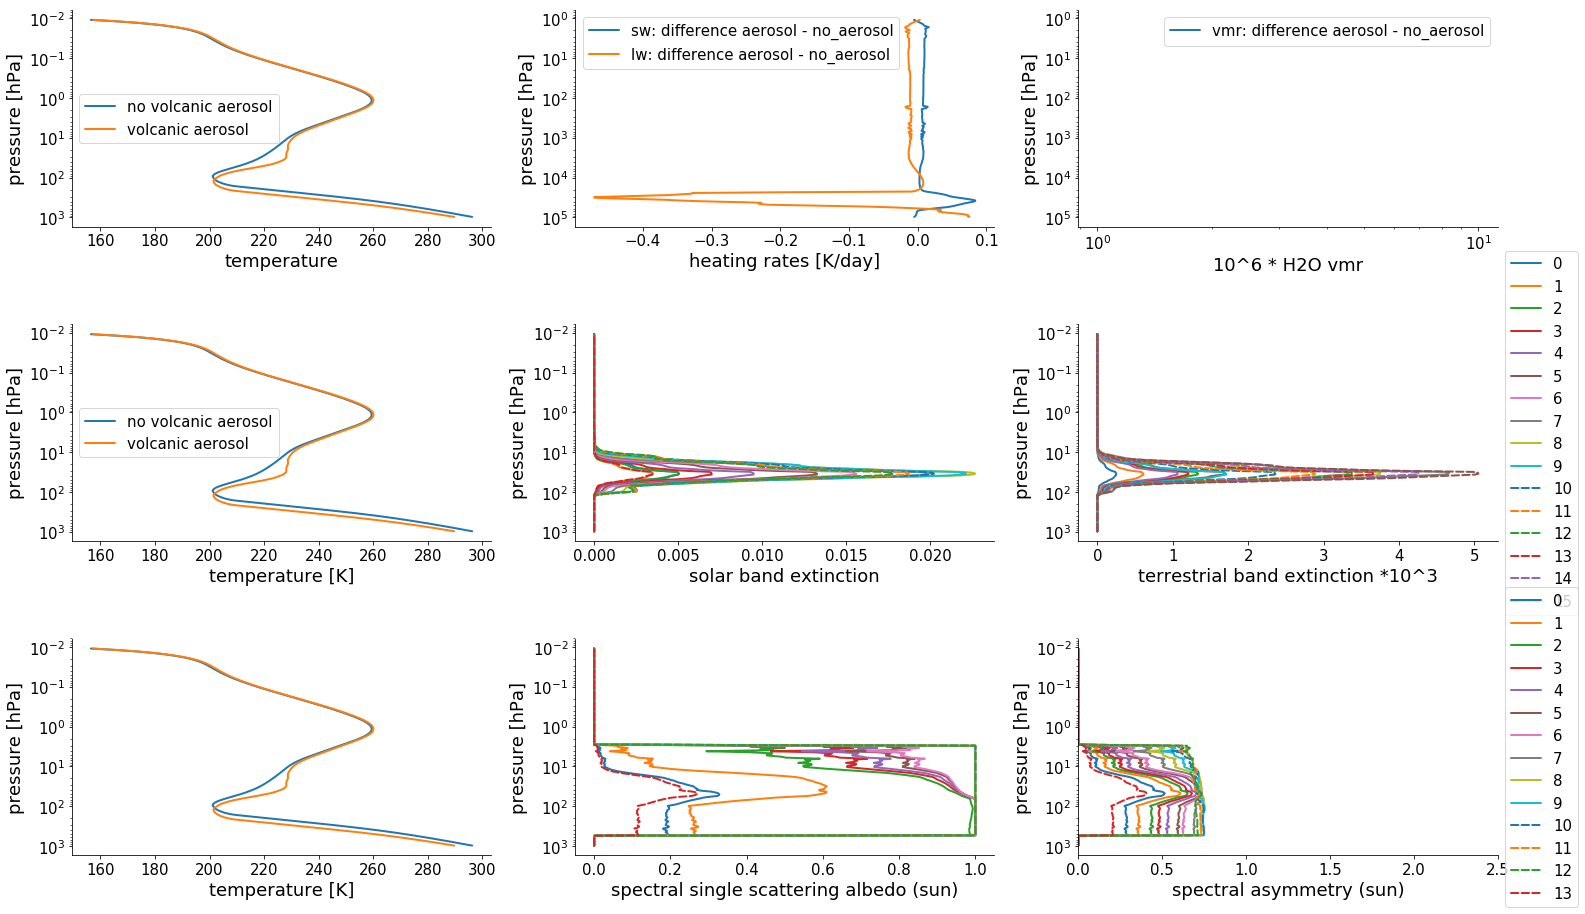

In [29]:
fig,ax=plt.subplots(3,3)
dataTimestep=31

ax[0,0].plot(noAerosolAtm['T'][-1, :], noAerosolAtm['plev'][:]/100, label='no volcanic aerosol')
ax[0,0].plot(AerosolAtm['T'][-1, :], AerosolAtm['plev'][:]/100, label='volcanic aerosol')
plt.gca().invert_yaxis()
ax[0,1].invert_yaxis()
ax[0,0].invert_yaxis()
ax[0,1].plot(-dataNoAerosol['radiation']['sw_htngrt'][dataNoAerosol['radiation']['sw_htngrt'].shape[0]-dataTimestep,:]+dataAerosol['radiation']['sw_htngrt'][dataAerosol['radiation']['sw_htngrt'].shape[0]-dataTimestep,:],dataNoAerosol['plev'][:], label='sw: difference aerosol - no_aerosol')
ax[0,1].plot(-dataNoAerosol['radiation']['lw_htngrt'][dataNoAerosol['radiation']['lw_htngrt'].shape[0]-dataTimestep,:]+dataAerosol['radiation']['lw_htngrt'][dataAerosol['radiation']['lw_htngrt'].shape[0]-dataTimestep,:],dataAerosol['plev'][:], label='lw: difference aerosol - no_aerosol')
ax[0,2].plot((-noAerosolAtm['H2O'][0,:]+AerosolAtm['H2O'][0,:])*10**6,dataAerosol['plev'], label='vmr: difference aerosol - no_aerosol')
#ax = plt.gca()
ax[1,0].plot(noAerosolAtm['T'][-1, :], noAerosolAtm['plev'][:]/100, label='no volcanic aerosol')
ax[1,0].plot(AerosolAtm['T'][-1, :], AerosolAtm['plev'][:]/100, label='volcanic aerosol')
for i in range(14):
    ax[1,1].plot(extSunx[i,:],AerosolAtm['plev'][:]/100 , label=str(i))
for i in range(16):
    ax[1,2].plot(extEarthx[i,:]*10**3, AerosolAtm['plev'][:]/100, label=str(i))
ax[2,0].plot(noAerosolAtm['T'][-1, :], noAerosolAtm['plev'][:]/100, label='no volcanic aerosol')
ax[2,0].plot(AerosolAtm['T'][-1, :], AerosolAtm['plev'][:]/100, label='volcanic aerosol')
for i in range(14):
    ax[2,1].plot(omegaSunx[i,:], AerosolAtm['plev'][:]/100 , label=str(i))
    ax[2,2].plot(gSunx[i,:],AerosolAtm['plev'][:]/100 , label=str(i))
#ax.set_ylim([pressureMin,max(atmosphere['plev'])])
#plt.gca().invert_yaxis()
ax[0,0].set_yscale('log')
ax[0,1].set_yscale('log')
ax[0,2].set_yscale('log')
ax[0,2].set_xscale('log')
ax[0,2].set_xscale('log')
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')
ax[1,2].set_yscale('log')
ax[2,0].set_yscale('log')
ax[2,1].set_yscale('log')
ax[2,2].set_yscale('log')
ax[0,2].invert_yaxis()
ax[1,0].invert_yaxis()
ax[1,1].invert_yaxis()
ax[1,2].invert_yaxis()
ax[2,0].invert_yaxis()
ax[2,2].invert_yaxis()
ax[2,1].invert_yaxis()

plt.gca().invert_yaxis()
#ax.plt(axis='equal')
ax[0,0].set_xlabel('temperature')
ax[0,0].set_ylabel('pressure [hPa]')
plt.gca().set_aspect('equal', adjustable='box')
ax[0,1].set_xlabel('heating rates [K/day]')
ax[0,1].set_ylabel('pressure [hPa]')
ax[0,2].set_xlabel('10^6 * H2O vmr')
ax[0,2].set_ylabel('pressure [hPa]')
ax[1,0].set_xlabel('temperature [K]')
ax[1,0].set_ylabel('pressure [hPa]')
ax[1,1].set_xlabel('solar band extinction')
ax[1,1].set_ylabel('pressure [hPa]')
ax[1,2].set_xlabel('terrestrial band extinction *10^3')
ax[1,2].set_ylabel('pressure [hPa]')
ax[2,0].set_xlabel('temperature [K]')
ax[2,0].set_ylabel('pressure [hPa]')
ax[2,1].set_xlabel('spectral single scattering albedo (sun)')
ax[2,1].set_ylabel('pressure [hPa]')
ax[2,2].set_xlabel('spectral asymmetry (sun)')
ax[2,2].set_ylabel('pressure [hPa]')
ax[2,2].set_xlim([0,2.5])
plt.subplots_adjust(bottom=0, left=.01, right=1.99, top=1.90, hspace=.45)
ax[0,0].legend()
ax[0,1].legend()
ax[0,2].legend()
ax[1,0].legend()

#ax[1,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1,2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
#ax[2,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[2,2].legend(loc='center left', bbox_to_anchor=(1, 0.5))

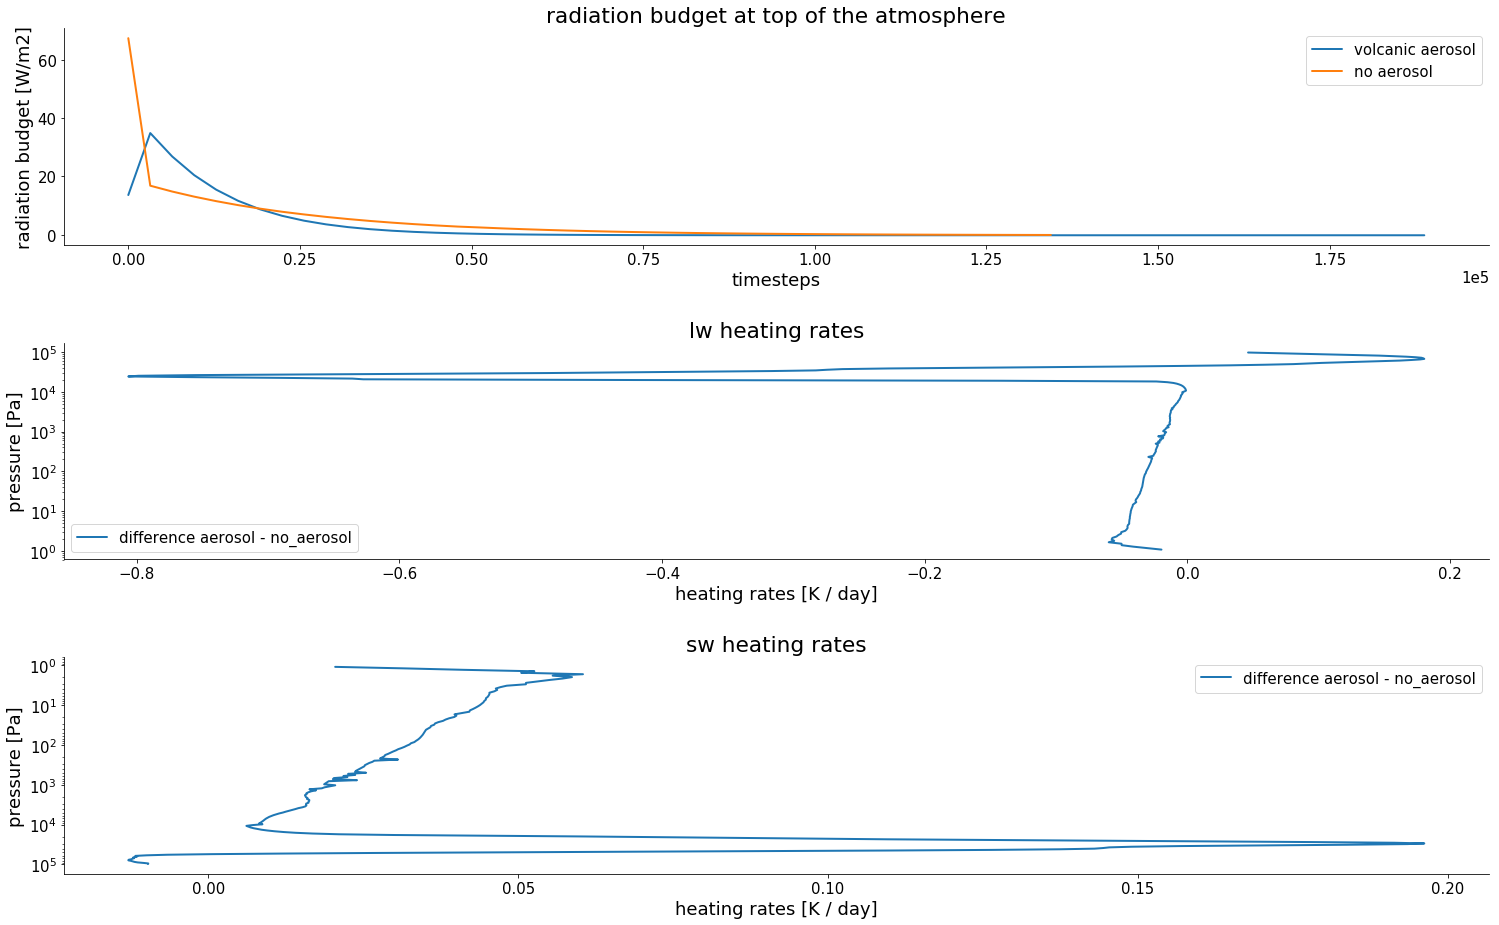

In [4]:
from netCDF4 import Dataset
dataNoAerosol=Dataset('/scratch/local1/m300733/convergence5.nc')
dataAerosol=Dataset('/scratch/local1/m300733/convergenceAerosol5.nc')
fig,ax=plt.subplots(3,1)
#plt.suptitle('run without aerosol',fontsize=16)
ax[0].plot(dataAerosol['time'],dataAerosol['radiation']['toa'],label='volcanic aerosol')
ax[0].plot(dataNoAerosol['time'],dataNoAerosol['radiation']['toa'],label='no aerosol')

ax[1].plot(-dataNoAerosol['radiation']['lw_htngrt'][5,:]+dataAerosol['radiation']['lw_htngrt'][5,:],dataAerosol['plev'],label='difference aerosol - no_aerosol')
#ax[1].plot(dataNoAerosol['radiation']['lw_htngrt'][5,:],dataNoAerosol['plev'],label='no aerosol')
#ax[2].plot(dataAerosol['radiation']['sw_htngrt'][5,:],dataAerosol['plev'],label='volcanic aerosol')
ax[2].plot(-dataNoAerosol['radiation']['sw_htngrt'][5,:]+dataAerosol['radiation']['sw_htngrt'][5,:],dataNoAerosol['plev'],label='difference aerosol - no_aerosol')

ax[0].set_title('radiation budget at top of the atmosphere')
ax[0].set_xlabel('timesteps')
ax[0].set_ylabel('radiation budget [W/m2]')
 
plt.gca().invert_yaxis()
ax[1].set_yscale('log')
#ax[1].invert_yaxis()
ax[1].set_title('lw heating rates')
ax[1].set_ylabel('pressure [Pa]')
ax[1].set_xlabel('heating rates [K / day]')

#ax.set_ylim([pressureMin,max(atmosphere['plev'])])
ax[2].set_yscale('log')
#ax[2].invert_yaxis()
ax[2].set_title('sw heating rates')
ax[2].set_xlabel('heating rates [K / day]')
ax[2].set_ylabel('pressure [Pa]')

plt.subplots_adjust(bottom=0, left=.01, right=1.99, top=1.90, hspace=.45)
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()

In [124]:
test=copy.copy(atmosphere)

KeyError: '__getstate__'

In [31]:
water=-noAerosolAtm['H2O'][0,:]+AerosolAtm['H2O'][0,:]
water

array([-3.89780672e-03, -3.86298722e-03, -3.82597818e-03, -3.78665807e-03,
       -3.74488272e-03, -3.70049866e-03, -3.65334822e-03, -3.60326108e-03,
       -3.55006320e-03, -3.49358171e-03, -3.43363375e-03, -3.37003102e-03,
       -3.30258008e-03, -3.23108646e-03, -3.16055964e-03, -3.09644636e-03,
       -3.03582646e-03, -2.97584809e-03, -2.91381144e-03, -2.84720729e-03,
       -2.77343121e-03, -2.68080745e-03, -2.56570257e-03, -2.43015704e-03,
       -2.27672455e-03, -2.10853111e-03, -1.92927800e-03, -1.74477552e-03,
       -1.56069202e-03, -1.38092834e-03, -1.20908247e-03, -1.04827020e-03,
       -9.00950939e-04, -7.68770722e-04, -6.50118830e-04, -5.43771944e-04,
       -4.49889282e-04, -3.68250746e-04, -2.98296485e-04, -2.39198754e-04,
       -1.89947985e-04, -1.49432142e-04, -1.16505657e-04, -9.00499400e-05,
       -6.80540944e-05, -5.03277772e-05, -3.64736811e-05, -2.57835907e-05,
       -1.76158047e-05, -1.14311193e-05, -7.41285528e-06, -5.60926053e-06,
       -4.38158415e-06, -

In [4]:
extSun=xr.open_dataset('/home/mpim/m300733/Documents/konrad/konrad/data/aerosolData/zonAverageExtSunbc_aeropt_cmip6_volc_lw_b16_sw_b14_1992.nc')
extEarth=xr.open_dataset('/home/mpim/m300733/Documents/konrad/konrad/data/aerosolData/zonAverageExtEarthbc_aeropt_cmip6_volc_lw_b16_sw_b14_1992.nc')
omegaSun=xr.open_dataset('/home/mpim/m300733/Documents/konrad/konrad/data/aerosolData/zonAverageOmegaSunbc_aeropt_cmip6_volc_lw_b16_sw_b14_1992.nc')
gSun=xr.open_dataset('/home/mpim/m300733/Documents/konrad/konrad/data/aerosolData/zonAveragegSunbc_aeropt_cmip6_volc_lw_b16_sw_b14_1992.nc')

In [7]:
extSun.ext_sun

<xarray.DataArray 'ext_sun' (solar_bands: 14, altitude: 70, month: 12)>
array([[[0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00],
        ...,
        [2.099151e-06, 2.386363e-06, ..., 9.768553e-07, 1.047851e-06],
        [1.345368e-06, 1.966700e-06, ..., 8.789775e-07, 8.111417e-07]],

       [[0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00],
        ...,
        [5.971994e-07, 6.704336e-07, ..., 2.725066e-07, 2.936851e-07],
        [3.816578e-07, 5.512694e-07, ..., 2.464229e-07, 2.286982e-07]],

       ...,

       [[0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, ..., 0.000000e+00, 0.000000e+00],
        ...,
        [4.784385e-05, 5.374552e-05, ..., 2.095917e-05, 2.268728e-05],
        [2.907740e-05, 4.249226e-05, ..., 1.906849e-05, 1.780341e-05]],

       [[0.000000e

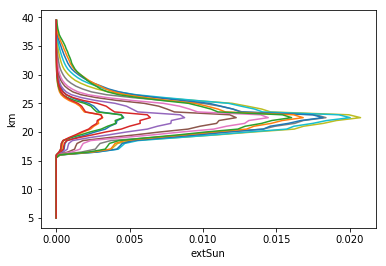

In [13]:
ax,fig=plt.subplots()
for i in range(14):
    plt.plot(extSun.ext_sun[i,:,1],extSun.altitude[:])
plt.xlabel('extSun')
plt.ylabel('km')
plt.show()